# Как найти стог сена в иголке? Практический проект по построению системы поиска аномалий

**Цель:** В этом домашнем задании вам предстоит настроить систему по поиску аномалий в банковских транзакциях. Мало того, что аномальных значений в данных меньше одного процента, так еще и переменные анонимизированные и представляют собой первые 28 главных компонент, полученных после PCA преобразования оригинальных данных (о которых мы ничего не знаем). Смогут ли бравые unsupervised методы справится с такой задачей? Можно ли работать в таких условиях? Кто подставил кролика Роджера? Ответы на некоторые их этих вопросов вы узнаете после выполнения задания :)

1. Скачайте датасет с [https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv](https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv) и
2. Проведите небольшой EDA (гистограммы и описательные статистики - обязательно)
3. Воспользуйтесь процентом аномалий, подсчитанным по переменной Class, как "экспертной оценкой" загрязненности нашего датасета
4. Попробуйте построить различные модели и алгоритмы, разобранные на занятии, используя полученную экспертную оценку для настройки параметров
5. Воспользуйтесь стандартными методами оценки качества бинарной классификации (особенно хорошо подойдёт classification report и confusion matrix), и, используя предсказания моделей и переменную Class, проверьте, действительно ли модели справляются со своей задачей и на сколько хорошо они это делают
6. При помощи tSNE и/или UMAP, постройте сжатое представление исходных данных и проверьте, действительно ли аномалии лежат достаточно далеко от основной массы точек

## Критерии оценки

- Базовый EDA - 2 балла
- Построены различные алгоритмы по поиску аномалий (основанные на расстояниях, плотностях и используя модели) - 5 баллов
- Проверка качества и отображение на сжатое пространство - 3 балла

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


import plotly
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
import plotly.tools as tls
 
import seaborn as sns
import sklearn
import scipy
import itertools 


%matplotlib inline

In [2]:
def get_outliers(data, function, threshold=3):
    outliers = pd.Series(data=[False]*len(data), index=data.index, name='is_outlier')
    
    for column in data.columns:
        anomalies = function(data, column, threshold=threshold)       
        outliers[anomalies[anomalies].index] = True        
    
    return outliers

def anomalies_report(outliers):
    print("Total number of outliers: {}\nPercentage of outliers:   {:.2f}".format(
            sum(outliers), 100*sum(outliers)/len(outliers)))  
 

In [3]:
data = pd.read_csv('creditcard.csv')
data.head()
# data=data[:5000]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## EDA

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

#### Данные без пропусков. Можно работать

In [7]:
columns=data.drop(['Class'],axis=1).columns.tolist()


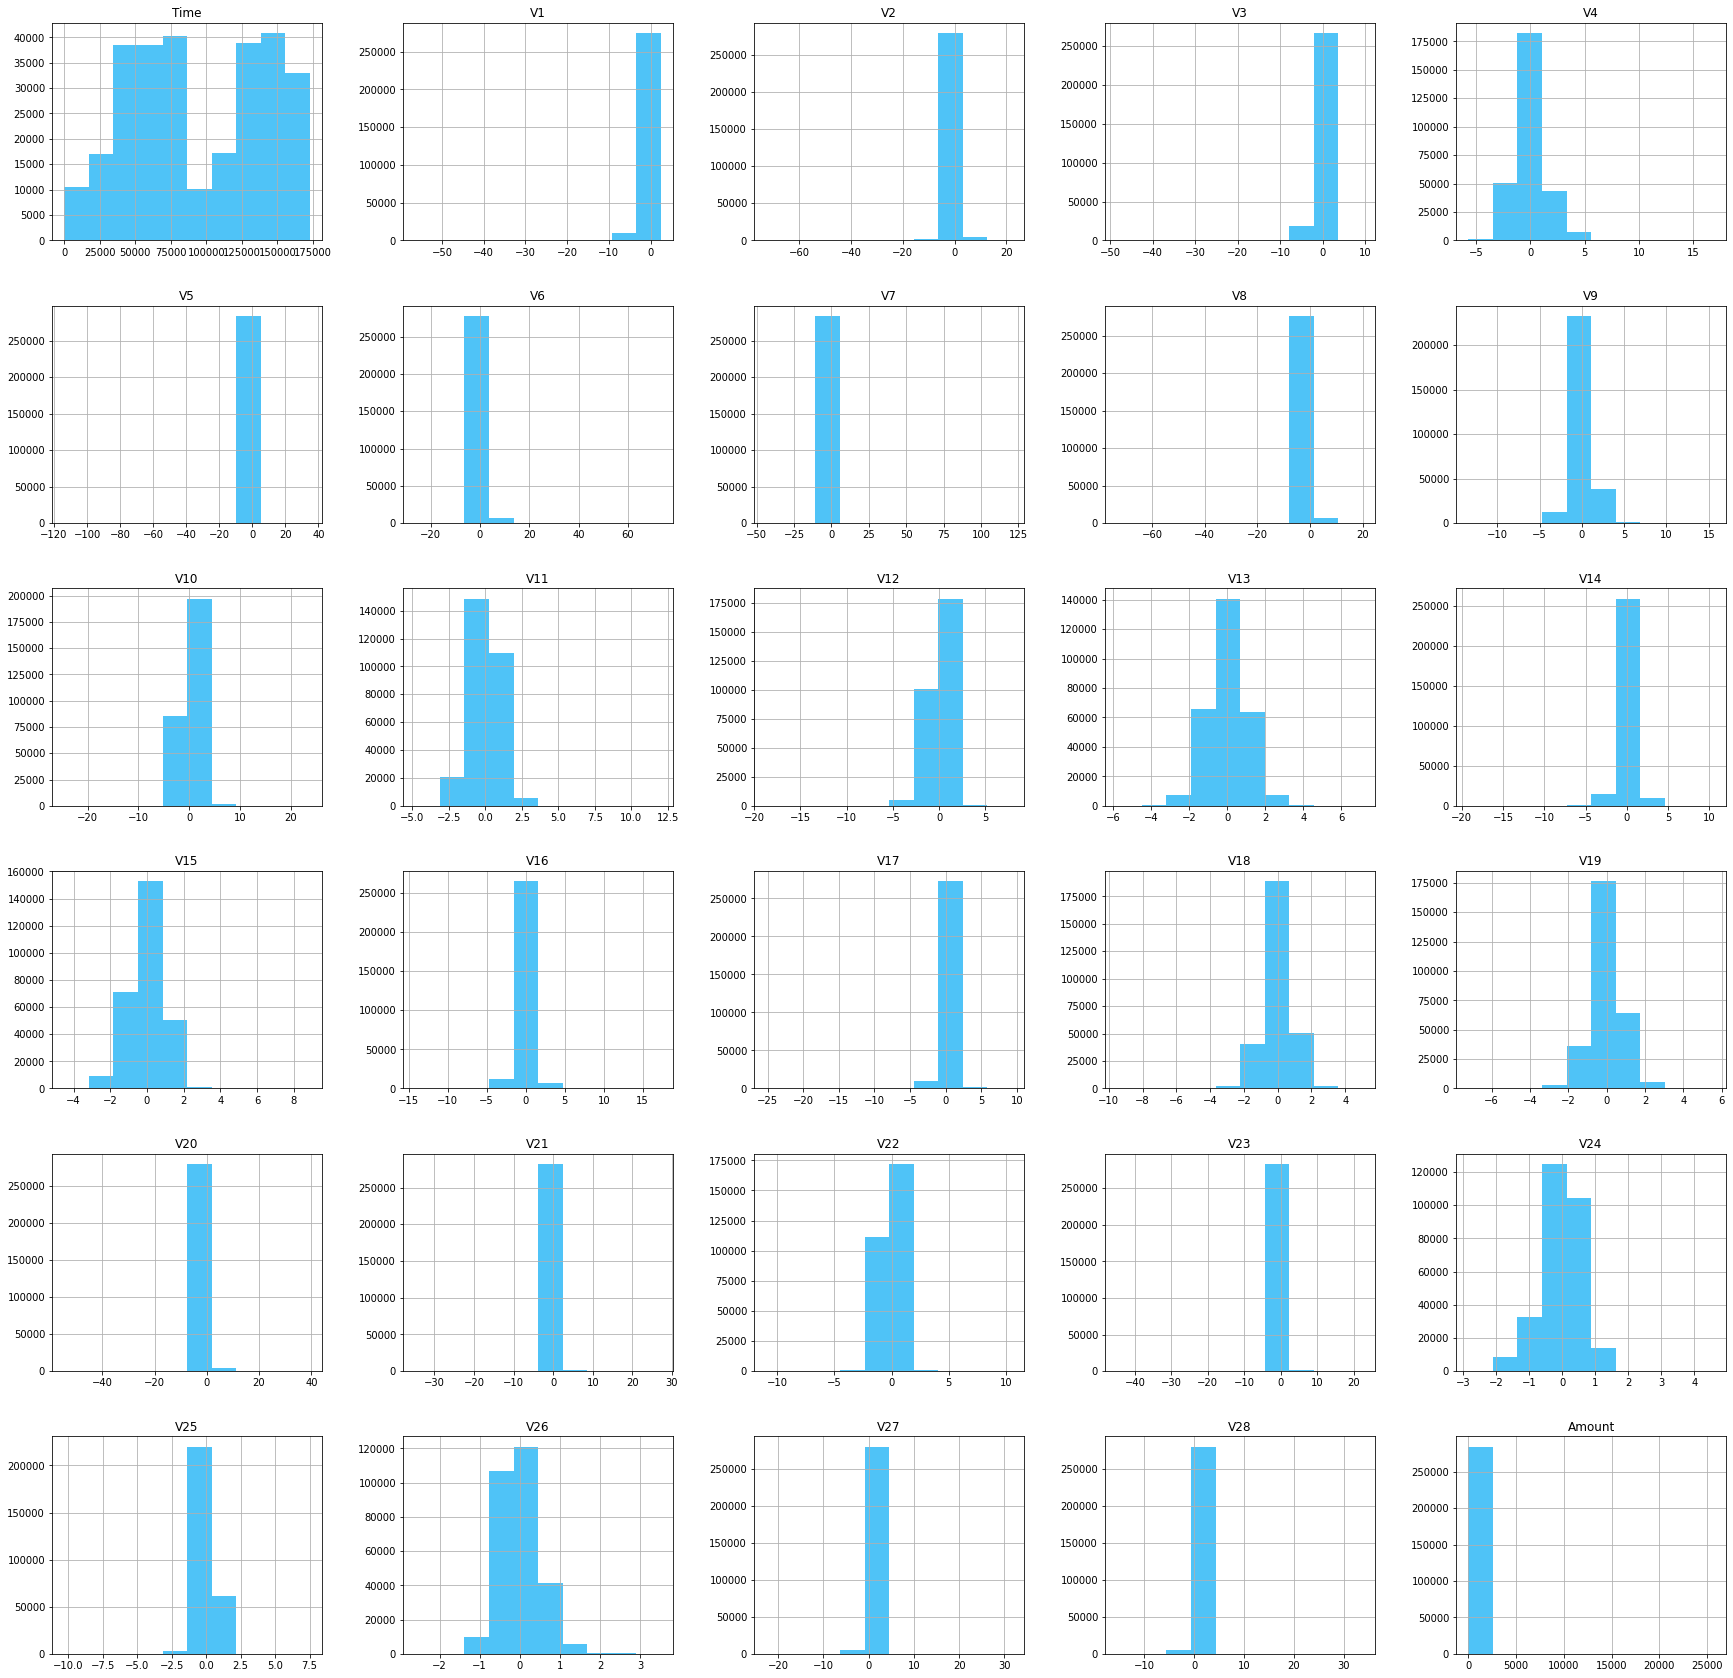

In [8]:
data[columns].hist(figsize=(30,30),color="#4FC3F7")
plt.show()

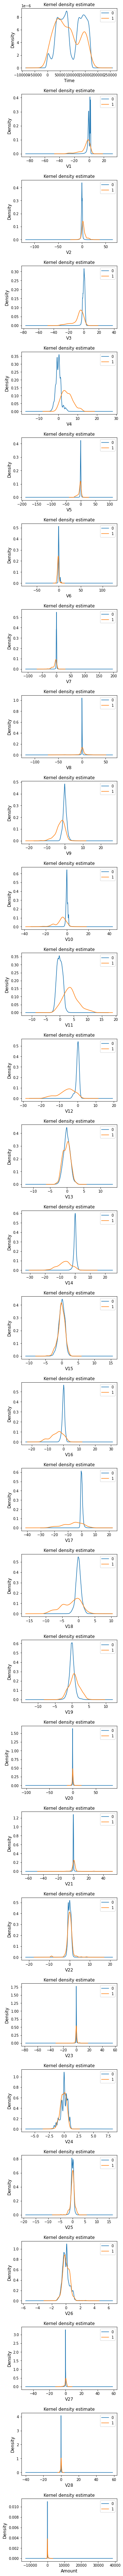

In [11]:
#!XL
data_grouped = data.groupby("Class")

# Создадим окружение для графиков, для каждой колонки два стобца
fig, axs = plt.subplots(nrows=len(columns), ncols=1, figsize=(5,100))

for index, column in enumerate(columns):


    # Во втором столбце отобразим график сглаженной плотности распределения на основе ядерной оценки
    data_grouped[column].plot(kind='kde', ax=axs[index])
    axs[index].set_title('Kernel density estimate')
    axs[index].set_xlabel(column, fontsize=12)
    axs[index].set_ylabel('Density', fontsize=12)
    axs[index].legend()

plt.tight_layout(pad=1.5)
plt.show()

### Экспертная оценка 

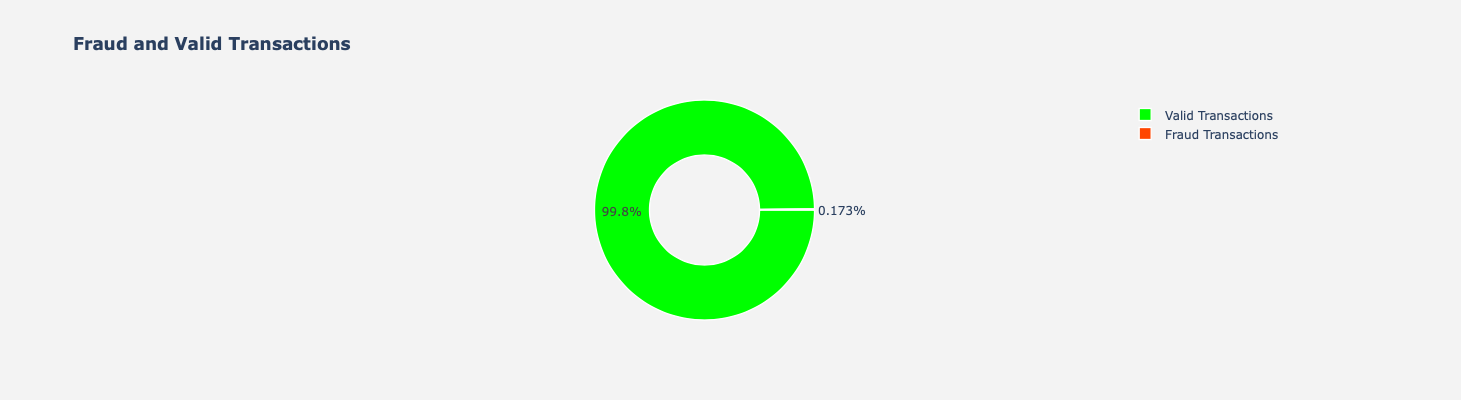

In [14]:
#!M
lab = data["Class"].value_counts().keys().tolist()
#values
val = data["Class"].value_counts().values.tolist()
 
trace = go.Pie(labels = ['Valid Transactions','Fraud Transactions'] ,
               values = val ,
               marker = dict(colors =  ["lime","orangered"],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "<b>Fraud and Valid Transactions<b>",
                        height=400,
                        width=700,
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )
 
dataf = [trace]
fig = go.Figure(data = dataf,layout = layout)
py.iplot(fig)

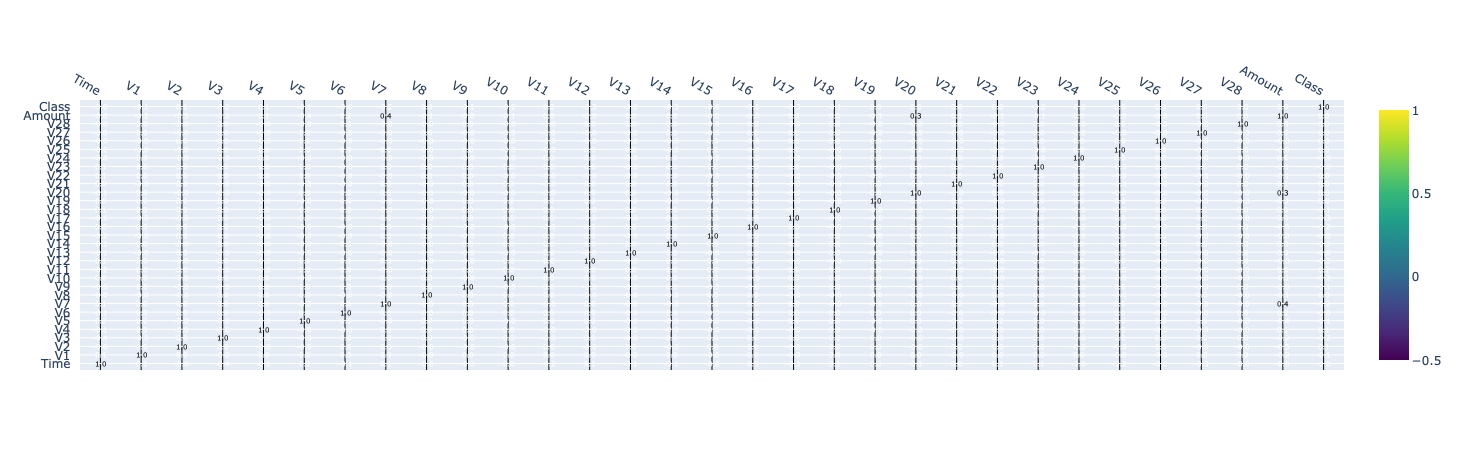

In [15]:
#!M
fig = ff.create_annotated_heatmap(round(data.corr(),1).values.tolist(),
                                  
                                  y=data.columns.tolist(),
                                  x=data.columns.tolist(), 
                                  colorscale="Viridis",
                                  showscale=True
                                 )
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].font.size = 7

fig.show()

### Поиск аномалий

In [16]:
from sklearn.preprocessing import RobustScaler

data_features = data.drop('Class', axis=1)
scaler = RobustScaler()
data_scaled = pd.DataFrame(
    data=scaler.fit_transform(data_features), 
    columns=data_features.columns
)
data_features_scaled = data_scaled.copy()
data_scaled['Class'] = data['Class']

In [18]:
#!
data_scaled

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.994983,-0.616237,-0.098602,1.228905,0.878152,-0.217859,0.631245,0.177406,0.142432,0.334787,...,0.026866,0.253109,-0.320791,0.032681,0.167619,-0.241182,0.816731,-0.246091,1.783274,0
1,-0.994983,0.524929,0.143100,-0.006970,0.293974,0.087726,0.164395,-0.105740,0.117064,-0.164482,...,-0.473332,-0.602719,0.363442,-0.479557,0.225462,0.313475,-0.063781,0.026519,-0.269825,0
2,-0.994972,-0.615587,-1.002407,0.830932,0.251024,-0.344345,1.778007,0.668164,0.420388,-1.179796,...,0.668917,0.714254,2.974603,-0.919589,-0.515430,-0.153111,-0.350218,-0.540962,4.983721,0
3,-0.994972,-0.440239,-0.178789,0.841250,-0.529808,0.033775,1.303832,0.175637,0.662489,-1.076888,...,-0.190105,-0.001408,-0.578786,-1.531963,0.944482,-0.298959,0.379163,0.382611,1.418291,0
4,-0.994960,-0.526089,0.579239,0.713861,0.265632,-0.270695,0.317183,0.491625,-0.546463,0.700808,...,0.048266,0.739092,-0.407980,0.126293,-0.333308,0.976221,1.347133,1.553716,0.670579,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,1.034951,-5.321622,7.135767,-5.222589,-1.285699,-4.073679,-1.999082,-4.409307,13.588260,1.585066,...,0.585633,0.098124,3.314091,-0.693006,2.126512,0.532055,5.820867,6.190862,-0.296653,0
284803,1.034963,-0.335820,-0.085979,0.967471,-0.451476,0.707747,1.142041,-0.014027,0.508439,0.512990,...,0.587444,0.856848,0.076436,-1.331299,-0.933155,-0.604145,0.414680,-0.493534,0.038986,0
284804,1.034975,0.850377,-0.261532,-1.788463,-0.337932,2.059687,2.832770,-0.299623,1.280019,0.390154,...,0.630455,0.533612,-0.085005,0.754500,0.373060,-0.062034,0.019227,-0.288058,0.641096,0
284805,1.034975,-0.115629,0.331602,0.272567,0.445763,-0.248270,0.769496,-0.645865,1.225405,0.357606,...,0.710499,0.740745,-0.491472,0.103549,-0.877058,1.054357,0.663921,0.710829,-0.167680,0


In [19]:
#!XL
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(perplexity=50, n_jobs=-1)
tsne_transformed = tsne.fit_transform(data_scaled)

plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=data['Class'])

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:577: UserWarning: The following variables cannot be serialized: tsne
  warnings.warn(message)


KeyboardInterrupt: 

### Простейшие методы

#### 3-сигмы

In [ ]:
def outlier_std(data, column, threshold=3):
    mean = data[column].mean()
    std = data[column].std()
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std
    anomalies = pd.concat([data[column]>up_bound, data[column]<low_bound], axis=1).any(1)
    return anomalies

In [ ]:
std_outliers = get_outliers(data_features, function=outlier_std)
anomalies_report(std_outliers)